In [ ]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from IPython.display import display, HTML, clear_output
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, Embedding, Concatenate, Flatten, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ReduceLROnPlateau

from random import shuffle
import datetime

In [2]:
r'''
full_sumo_data: all sumo data with ocupation (requested in sumo office)

full_sumo_data_past_10: all sumo data with ocupation and 10 minutes past ocupation (requested in sumo office)

'''

full_sumo_data_path = r'C:\Users\ing_l\Tesis grado\Data\SUMO\full_SUMO_data_ocupation.csv'
full_sumo_data_past_10_path = r'C:\Users\ing_l\Tesis grado\Data\SUMO\full_SUMO_data_past_10_ocupation.csv'
full_sumo_data_past_30_path = r'C:\Users\ing_l\Tesis grado\Data\SUMO\full_SUMO_data_past_30_ocupation.csv'

In [3]:
data = pd.read_csv(full_sumo_data_path)
data.drop('Unnamed: 0', axis=1, inplace=True)

In [4]:
#Delete oficina SUMO and Tribunal de Faltas
data = data.loc[data.parquimetro != 37]
data = data.loc[data.parquimetro != 190]

In [5]:
data['fecha_emision'] = data['fecha_emision'].apply(lambda x: pd.to_datetime(x, dayfirst=True).date())

In [6]:
data['tiempo_emision'] = data['tiempo_emision'].apply(lambda x: pd.to_datetime(x, dayfirst=True).time())

In [7]:
d = data.copy()

In [8]:
d

,parquimetro,fecha_emision,tiempo_emision,operacion,tiempo_estacionado,direccion,latitud,longitud,ocupacion
0,16,2019-01-01,10:55:00,0,10:00,Belgrano 660,-37.328838,-59.134455,0
1,60,2019-01-01,16:25:00,1,0:00,Chacabuco 357,-37.328143,-59.136740,1
2,60,2019-01-01,16:25:00,0,0:00,Chacabuco 357,-37.328143,-59.136740,0
3,60,2019-01-01,16:25:00,1,0:00,Chacabuco 357,-37.328143,-59.136740,1
4,60,2019-01-01,17:11:00,0,0:46,Chacabuco 357,-37.328143,-59.136740,0
...,...,...,...,...,...,...,...,...,...
2957537,61,2019-12-31,13:20:00,0,0:38,Yrigoyen 847,-37.323967,-59.139628,1
2957538,61,2019-12-31,13:28:00,0,2:22,Yrigoyen 847,-37.323967,-59.139628,0
2957539,61,2019-12-31,13:28:00,1,2:22,Yrigoyen 847,-37.323967,-59.139628,1
2957540,61,2019-12-31,13:28:00,0,2:22,Yrigoyen 847,-37.323967,-59.139628,0


In [9]:
def normalize_time(time):
    '''
    normalize time (datetime.time to values bertween 0 and 1
    '''
    max_time = 24 * 60 * 60 + 60 * 60 + 60
    return (time.hour * 60 * 60 + time.minute * 60 + time.second) / max_time

def get_season(fecha):
    '''
    obtain the season of each row
    '''
    fecha = pd.to_datetime(fecha, dayfirst=True)
    d = fecha.day
    m = fecha.month * 100
    md = m + d
    if ((md >= 921) and (md <= 1220)):
        season = 0  # spring
    elif ((md >= 1221) and (md <= 320)):
        season = 1  # summer
    elif ((md >= 321) and (md <= 620)):
        season = 2  # fall
    elif ((md >= 621) and (md <= 920)):
        season = 3  # winter
    return season

In [10]:
#Normalize time to values between 0 and 1
d['tiempo_emision'] = d['tiempo_emision'].apply(normalize_time)

In [11]:
#Add weekday
d['dia_de_la_semana'] = d['fecha_emision'].apply(lambda x: pd.Timestamp(x).weekday())

In [12]:
#Add month
d['mes'] = d['fecha_emision'].apply(lambda x: x.month)

In [13]:
d = d[['parquimetro', 'fecha_emision', 'dia_de_la_semana', 'mes', 'tiempo_emision', 'operacion', 'ocupacion']]

In [14]:
d

,parquimetro,fecha_emision,dia_de_la_semana,mes,tiempo_emision,operacion,ocupacion
0,16,2019-01-01,1,1,0.436376,0,0
1,60,2019-01-01,1,1,0.656229,1,1
2,60,2019-01-01,1,1,0.656229,0,0
3,60,2019-01-01,1,1,0.656229,1,1
4,60,2019-01-01,1,1,0.686875,0,0
...,...,...,...,...,...,...,...
2957537,61,2019-12-31,1,12,0.532978,0,1
2957538,61,2019-12-31,1,12,0.538308,0,0
2957539,61,2019-12-31,1,12,0.538308,1,1
2957540,61,2019-12-31,1,12,0.538308,0,0


In [15]:
max_street_num = d['parquimetro'].max()

In [16]:
print('max_street_num:', max_street_num)

max_street_num: 96


In [17]:
def add_past_ocupation(data, t=10):
    '''
    Adds past ocupation to the original df. Past ocupation is the
    ocupation time minuts before the current row time.
    '''
    
    
    df = data.copy()

    
    df['ocupacion_pasada'] = 0
    df['diferencia_ocupacion_pasada'] = 0
    
    out = pd.DataFrame(columns=df.columns)

    
    max_time = 24 * 60 * 60 + 60 * 60 + 60
    t = (t * 60) / max_time
    
    for street in df['parquimetro'].drop_duplicates().sort_values():
        clear_output()
        print('Street:', street)
        d_street = df.loc[df['parquimetro'] == street]
        
        for date in d_street['fecha_emision'].drop_duplicates().sort_values():
            d_date = d_street.loc[d_street['fecha_emision'] == date].reset_index(drop=True)
            
            def add_past_ocupation_row(row):
                nonlocal d_date, t
                past_time = row['tiempo_emision'] - t

                past_data = d_date[d_date['tiempo_emision'] <= past_time]
                if len(past_data) > 0:
                    past_time_row_ix = past_data.tiempo_emision.idxmax()
                    row['ocupacion_pasada'] = d_date.iloc[past_time_row_ix]['ocupacion']
                    row['diferencia_ocupacion_pasada'] = row['ocupacion'] - d_date.iloc[past_time_row_ix]['ocupacion']
                else:
                    row['diferencia_ocupacion_pasada'] = 0
                    row['ocupacion_pasada'] = row['ocupacion']
                return row
            
            data_to_add = d_date.apply(add_past_ocupation_row, axis=1)
        
            out = out.append(data_to_add)
                
            '''for ix in d_date.index:
                row_to_add = d_date.iloc[ix]
                past_time = row_to_add['tiempo_emision'] - t
                
                past_data = d_date[d_date['tiempo_emision'] <= past_time]
                if len(past_data) > 0:
                    past_time_row_ix = past_data.tiempo_emision.idxmax()
                    row_to_add['ocupacion_pasada'] = d_date.iloc[past_time_row_ix]['ocupacion']
                else:
                    row_to_add['ocupacion_pasada'] = row_to_add['ocupacion']
                
                out = out.append(row_to_add)
            '''    
    return out

In [18]:
#new_data = add_past_ocupation(d, t=10)

#new_data.reset_index(drop=True).to_csv(full_sumo_data_past_10_path)

In [19]:
d = pd.read_csv(full_sumo_data_past_10_path)
d

,Unnamed: 0,parquimetro,fecha_emision,dia_de_la_semana,mes,tiempo_emision,operacion,ocupacion,ocupacion_pasada,diferencia_ocupacion_pasada
0,0,0,2019-01-02,2,1,0.383078,1,1,1,0
1,1,0,2019-01-02,2,1,0.385743,1,2,2,0
2,2,0,2019-01-02,2,1,0.387075,1,3,3,0
3,3,0,2019-01-02,2,1,0.389740,0,2,1,1
4,4,0,2019-01-02,2,1,0.389740,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...
2951872,2951872,96,2019-12-30,0,12,0.680213,0,0,0,0
2951873,2951873,96,2019-12-30,0,12,0.714191,1,1,0,1
2951874,2951874,96,2019-12-30,0,12,0.720187,0,0,0,0
2951875,2951875,96,2019-12-30,0,12,0.771486,1,1,0,1


In [20]:
def prepare_train_data(data, validation_split=0.2):
    '''
    Prepare train data
    
    Parameter:
        data: (DataFrame) data from one street.
        validation_split: (float) quantity of the data that will be used for validation.
    Out:
        train_time, train_street, train_weekday, train_month, targets: (ndarray) numpy arrays
            that contains time, street, weekday, month and target ocupation, respectively.
    '''   
    train_time = []
    train_street = []
    train_weekday = []
    train_month = []
    train_last_past_ocup = []
    train_past_ocup = []
    train_dif_past_ocup = []
    train_targets = []
    
    for date in data['fecha_emision'].drop_duplicates():
        d = data.loc[data['fecha_emision'] == date].copy()
        
        train_time.append(d['tiempo_emision'].values[1:])
        train_street.append(d['parquimetro'].values[1:])
        train_weekday.append(d['dia_de_la_semana'].values[1:])
        train_month.append(d['mes'].values[1:])
        train_last_past_ocup.append(d['ocupacion'].values[0:-1])
        train_dif_past_ocup.append(d['diferencia_ocupacion_pasada'].values[1:])
        train_past_ocup.append(d['ocupacion_pasada'].values[1:])
        train_targets.append(d['ocupacion'].values[1:])
    
    train_time = [y for x in train_time for y in x]
    train_street = [y for x in train_street for y in x]
    train_weekday = [y for x in train_weekday for y in x]
    train_month = [y for x in train_month for y in x]
    train_dif_past_ocup = [y for x in train_dif_past_ocup for y in x]
    train_last_past_ocup = [y for x in train_last_past_ocup for y in x]
    train_past_ocup = [y for x in train_past_ocup for y in x]
    train_targets = [y for x in train_targets for y in x]
    
    percentile = int(len(train_time)-len(train_time)*validation_split)
    t_time = train_time[:percentile]
    t_s = train_street[:percentile]
    t_w = train_weekday[:percentile]
    t_m = train_month[:percentile]
    t_dif_p_ocup = train_dif_past_ocup[:percentile]
    t_last_p_ocup = train_last_past_ocup[:percentile]
    t_p_ocup = train_past_ocup[:percentile]
    t_targ = train_targets[:percentile]
    
    v_time = train_time[percentile:]
    v_s = train_street[percentile:]
    v_w = train_weekday[percentile:]
    v_m = train_month[percentile:]
    v_dif_p_ocup = train_dif_past_ocup[percentile:]
    v_last_p_ocup = train_last_past_ocup[percentile:]
    v_p_ocup = train_past_ocup[percentile:]
    v_targ = train_targets[percentile:]
    
    return t_time, t_s, t_w, t_m, t_dif_p_ocup, t_last_p_ocup, t_p_ocup, t_targ, v_time, v_s, v_w, v_m, v_dif_p_ocup, v_last_p_ocup, v_p_ocup, v_targ 

train_time = []
train_street = []
train_weekday = []
train_month = []
train_dif_past_ocup = []
train_last_past_ocup = []
train_past_ocup = []
train_targets = []
val_time = []
val_street = []
val_weekday = []
val_month = []
val_dif_past_ocup = []
val_last_past_ocup = []
val_past_ocup = []
val_targets = []

for street in d['parquimetro'].drop_duplicates().sort_values():
    clear_output()
    print('Calle num: ', street)
    t_time, t_s, t_w, t_m, t_dif_p_ocup, t_last_p_ocup, t_p_ocup, t_targ, v_time, v_s, v_w, v_m, v_dif_p_ocup, v_last_p_ocup, v_p_ocup, v_targ  = prepare_train_data(d.loc[d.parquimetro == street], validation_split=0.2)
    train_time.append(t_time)
    train_street.append(t_s)
    train_weekday.append(t_w)
    train_month.append(t_m)
    train_dif_past_ocup.append(t_dif_p_ocup)
    train_last_past_ocup.append(t_last_p_ocup)
    train_past_ocup.append(t_p_ocup)
    train_targets.append(t_targ)
    
    val_time.append(v_time)
    val_street.append(v_s)
    val_weekday.append(v_w)
    val_month.append(v_m)
    val_dif_past_ocup.append(v_dif_p_ocup)
    val_last_past_ocup.append(v_last_p_ocup)
    val_past_ocup.append(v_p_ocup)
    val_targets.append(v_targ)

Calle num:  96


In [21]:
train_time = [y for x in train_time for y in x]
train_street = [y for x in train_street for y in x]
train_weekday = [y for x in train_weekday for y in x]
train_month = [y for x in train_month for y in x]
train_past_ocup = [y for x in train_past_ocup for y in x]
train_last_past_ocup = [y for x in train_last_past_ocup for y in x]
train_dif_past_ocup = [y for x in train_dif_past_ocup for y in x]
train_targets = [y for x in train_targets for y in x]


val_time = [y for x in val_time for y in x]
val_street = [y for x in val_street for y in x]
val_weekday = [y for x in val_weekday for y in x]
val_month = [y for x in val_month for y in x]
val_past_ocup = [y for x in val_past_ocup for y in x]
val_last_past_ocup = [y for x in val_last_past_ocup for y in x]
val_dif_past_ocup = [y for x in val_dif_past_ocup for y in x]
val_targets = [y for x in val_targets for y in x]

In [22]:
to_shuffle = list(zip(train_time, train_street, train_weekday, train_month, train_dif_past_ocup, train_past_ocup, train_last_past_ocup, train_targets))
shuffle(to_shuffle)
train_time, train_street, train_weekday, train_month, train_dif_past_ocup, train_past_ocup, train_last_past_ocup, train_targets = zip(*to_shuffle)

In [23]:
to_shuffle = list(zip(val_time, val_street, val_weekday, val_month, val_dif_past_ocup, val_past_ocup, val_last_past_ocup, val_targets))
shuffle(to_shuffle)
val_time, val_street, val_weekday, val_month, val_dif_past_ocup, val_past_ocup, val_last_past_ocup, val_targets = zip(*to_shuffle)

In [24]:
train_time = tf.convert_to_tensor(train_time, np.float64)
train_street = tf.convert_to_tensor(train_street, np.float64)
train_weekday = tf.convert_to_tensor(train_weekday, np.float64)
train_month = tf.convert_to_tensor(train_month, np.float64)
train_dif_past_ocup = tf.convert_to_tensor(train_dif_past_ocup, np.float64)
train_past_ocup = tf.convert_to_tensor(train_past_ocup, np.float64)
train_last_past_ocup = tf.convert_to_tensor(train_last_past_ocup, np.float64)
train_targets = tf.convert_to_tensor(train_targets, np.float64)

In [25]:
val_time = tf.convert_to_tensor(val_time, np.float64)
val_street = tf.convert_to_tensor(val_street, np.float64)
val_weekday = tf.convert_to_tensor(val_weekday, np.float64)
val_month = tf.convert_to_tensor(val_month, np.float64)
val_dif_past_ocup = tf.convert_to_tensor(val_dif_past_ocup, np.float64)
val_past_ocup = tf.convert_to_tensor(val_past_ocup, np.float64)
val_last_past_ocup = tf.convert_to_tensor(val_last_past_ocup, np.float64)
val_targets = tf.convert_to_tensor(val_targets, np.float64)

In [26]:
#Time 
input_time = Input(shape=(1), name='input_time')
#dense_time = Dense(128, activation='relu')(input_time)

#Street
input_street = Input(shape=(1), name='input_street')
emb_street = Embedding(input_length=1, input_dim=max_street_num+1, output_dim=80)(input_street)
flat_street = Flatten()(emb_street)

#Weekday
input_weekday = Input(shape=(1), name='input_weekday')
emb_weekday = Embedding(input_length=1, input_dim=7, output_dim=50)(input_weekday)
flat_weekday = Flatten()(emb_weekday)

#Month
input_month = Input(shape=(1), name='input_month')
emb_month = Embedding(input_length=1, input_dim=13, output_dim=40)(input_month)
flat_month = Flatten()(emb_month)

#Past ocupation
input_past_ocupation = Input(shape=(1), name='input_past_ocupation')

#Last past ocupation
input_last_past_ocupation = Input(shape=(1), name='input_last_past_ocupation')


concat = Concatenate(axis=-1)
input_merge = concat([input_time, flat_street])
input_merge = concat([input_merge, flat_weekday])
input_merge = concat([input_merge, flat_month])
input_merge = concat([input_merge, input_last_past_ocupation])

d = BatchNormalization()(input_merge)
#d = Dropout(0.25)(d)
d = Dense(128, activation='relu')(d)
d = BatchNormalization()(d)
d = Dropout(0.25)(d)
d = Dense(256, activation='relu')(d)
#d = Dropout(0.25)(d)
d = Dense(512, activation='relu')(d)
#d = Dropout(0.25)(d)
#d = Dense(128, activation='relu')(d)
#d = Dropout(0.5)(d)
#d = Dense(128, activation='relu')(d)
out = Dense(1, activation='linear')(d)

model = Model(inputs=[input_time, input_street, input_weekday, input_last_past_ocupation, input_month], outputs=out)
#model = Model(inputs=[input_time, input_street, input_weekday, input_month], outputs=out)
model.summary()
model.compile(loss='MSE', optimizer='adam', metrics=['MAE'])

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_street (InputLayer)       [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 1, 80)        7760        input_street[0][0]               
__________________________________________________________________________________________________
input_weekday (InputLayer)      [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_time (InputLayer)         [(None, 1)]          0                                            
______________________________________________________________________________________________

In [27]:
red_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=4, min_lr=0.00000001)

#h = model.fit([train_time, train_street, train_weekday, train_month], train_targets, epochs=5, batch_size=32, validation_data=([val_time, val_street, val_weekday, val_month], val_targets))#, callbacks=[red_lr])
# 24.68 vs 26.05
#h = model.fit([train_time, train_street, train_weekday, train_past_ocup, train_month], train_targets, epochs=10, batch_size=128, validation_data=([val_time, val_street, val_weekday, val_past_ocup, val_month], val_targets), callbacks=[red_lr])
#arriba 5.7 abajo 11.7
#h = model.fit([train_time, train_street, train_weekday, train_month], train_targets, epochs=30, batch_size=64, validation_data=([val_time, val_street, val_weekday, val_month], val_targets), callbacks=[red_lr])


#Now im trying with dif ocupation // 3.0775 
#h = model.fit([train_time, train_street, train_weekday, train_past_ocup, train_month], train_dif_past_ocup, epochs=10, batch_size=256, validation_data=([val_time, val_street, val_weekday, val_past_ocup, val_month], val_dif_past_ocup), callbacks=[red_lr])

# train: 1.7 // test: 3.0
h = model.fit([train_time, train_street, train_weekday, train_last_past_ocup, train_month], train_targets, epochs=10, batch_size=32, validation_data=([val_time, val_street, val_weekday, val_last_past_ocup, val_month], val_targets), callbacks=[red_lr])

Train on 2337946 samples, validate on 584541 samples
Epoch 1/10
2337946/2337946 [==============================] - 282s 121us/sample - loss: 2.2478 - MAE: 1.1744 - val_loss: 1.6156 - val_MAE: 1.0568
Epoch 2/10
2337946/2337946 [==============================] - 275s 118us/sample - loss: 1.8699 - MAE: 1.0969 - val_loss: 1.8108 - val_MAE: 1.0918
Epoch 3/10
2337946/2337946 [==============================] - 272s 116us/sample - loss: 1.8138 - MAE: 1.0847 - val_loss: 2.4407 - val_MAE: 1.1975
Epoch 4/10
2337946/2337946 [==============================] - 268s 115us/sample - loss: 1.7829 - MAE: 1.0784 - val_loss: 1.9987 - val_MAE: 1.1075
Epoch 5/10
2337946/2337946 [==============================] - 270s 116us/sample - loss: 1.7688 - MAE: 1.0750 - val_loss: 2.1559 - val_MAE: 1.1420
Epoch 6/10
2337946/2337946 [==============================] - 269s 115us/sample - loss: 1.6815 - MAE: 1.0560 - val_loss: 2.1345 - val_MAE: 1.1225
Epoch 7/10
2337946/2337946 [==============================] - 268s 114u

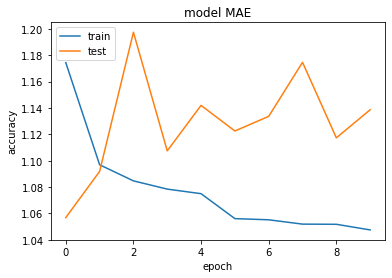

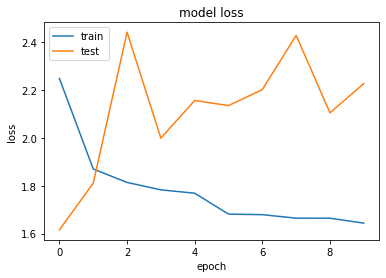

In [28]:
%matplotlib inline
import pickle
import numpy as np
from matplotlib import pyplot as plt

plt.plot(h.history['MAE'])
plt.plot(h.history['val_MAE'])
plt.title('model MAE')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(h.history['loss'])
plt.plot(h.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [29]:
def denormalize_time(time):
    '''
    denormalize time (datetime.time to values bertween 0 and 1
    '''
    max_time = 24 * 60 * 60 + 60 * 60 + 60
    return pd.Timestamp(time * max_time, unit='s').time()

In [30]:
i = 0

a = tf.reshape(val_time[i], (1,1))

b = tf.reshape(val_street[i], (1,1))

c = tf.reshape(val_weekday[i], (1,1))

d = tf.reshape(val_past_ocup[i], (1,1))

e = tf.reshape(val_last_past_ocup[i], (1,1))

f = tf.reshape(val_month[i], (1,1))

    
print('Time:      ', denormalize_time(a.numpy()[0][0]))
print('Street:    ', b.numpy()[0][0])
print('Weekday:   ', c.numpy()[0][0])
print('Past ocup: ', d.numpy()[0][0])
print('Last past ocup: ', e.numpy()[0][0])
print('Month:     ', f.numpy()[0][0])
print('')
print('Targets:       ', val_targets[i].numpy())
print('Dif past ocup: ', val_dif_past_ocup[i].numpy())

Time:       17:56:00
Street:     18.0
Weekday:    2.0
Past ocup:  9.0
Last past ocup:  8.0
Month:      12.0

Targets:        7.0
Dif past ocup:  -2.0


In [31]:
print('Valor predicho:   ', model.predict([a, b, c, e, f])[0][0])

print('Ocup real:        ', val_targets[i].numpy())
#print('Dif past ocup:    ', val_dif_past_ocup[i].numpy())

Valor predicho:    7.990077
Ocup real:         7.0


# Otra red neuronal, donde en vez de ser una regresion que sea un clasificador de 0 y 1 (entrada o salida)

In [32]:
d = pd.read_csv(full_sumo_data_past_10_path)
d

,Unnamed: 0,parquimetro,fecha_emision,dia_de_la_semana,mes,tiempo_emision,operacion,ocupacion,ocupacion_pasada,diferencia_ocupacion_pasada
0,0,0,2019-01-02,2,1,0.383078,1,1,1,0
1,1,0,2019-01-02,2,1,0.385743,1,2,2,0
2,2,0,2019-01-02,2,1,0.387075,1,3,3,0
3,3,0,2019-01-02,2,1,0.389740,0,2,1,1
4,4,0,2019-01-02,2,1,0.389740,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...
2951872,2951872,96,2019-12-30,0,12,0.680213,0,0,0,0
2951873,2951873,96,2019-12-30,0,12,0.714191,1,1,0,1
2951874,2951874,96,2019-12-30,0,12,0.720187,0,0,0,0
2951875,2951875,96,2019-12-30,0,12,0.771486,1,1,0,1


In [33]:
def prepare_train_data(data, validation_split=0.2):
    '''
    Prepare train data
    
    Parameter:
        data: (DataFrame) data from one street.
        validation_split: (float) quantity of the data that will be used for validation.
    Out:
        train_time, train_street, train_weekday, train_month, targets: (ndarray) numpy arrays
            that contains time, street, weekday, month and target ocupation, respectively.
    '''   
    train_time = []
    train_street = []
    train_weekday = []
    train_month = []
    train_last_past_ocup = []
    train_targets = []
    
    for date in data['fecha_emision'].drop_duplicates():
        d = data.loc[data['fecha_emision'] == date].copy()
        
        train_time.append(d['tiempo_emision'].values[:-1])
        train_street.append(d['parquimetro'].values[:-1])
        train_weekday.append(d['dia_de_la_semana'].values[:-1])
        train_month.append(d['mes'].values[:-1])
        train_last_past_ocup.append(d['ocupacion'].values[:-1])
        train_targets.append(d['operacion'].values[1:])
    
    train_time = [y for x in train_time for y in x]
    train_street = [y for x in train_street for y in x]
    train_weekday = [y for x in train_weekday for y in x]
    train_month = [y for x in train_month for y in x]
    train_last_past_ocup = [y for x in train_last_past_ocup for y in x]
    train_targets = [y for x in train_targets for y in x]
    
    percentile = int(len(train_time)-len(train_time)*validation_split)
    t_time = train_time[:percentile]
    t_s = train_street[:percentile]
    t_w = train_weekday[:percentile]
    t_m = train_month[:percentile]
    t_last_p_ocup = train_last_past_ocup[:percentile]
    t_targ = train_targets[:percentile]
    
    v_time = train_time[percentile:]
    v_s = train_street[percentile:]
    v_w = train_weekday[percentile:]
    v_m = train_month[percentile:]
    v_last_p_ocup = train_last_past_ocup[percentile:]
    v_targ = train_targets[percentile:]
    
    return t_time, t_s, t_w, t_m, t_last_p_ocup, t_targ, v_time, v_s, v_w, v_m, v_last_p_ocup, v_targ 

train_time = []
train_street = []
train_weekday = []
train_month = []
train_last_past_ocup = []
train_targets = []
val_time = []
val_street = []
val_weekday = []
val_month = []
val_last_past_ocup = []
val_targets = []

for street in d['parquimetro'].drop_duplicates().sort_values():
    clear_output()
    print('Calle num: ', street)
    t_time, t_s, t_w, t_m, t_last_p_ocup, t_targ, v_time, v_s, v_w, v_m, v_last_p_ocup, v_targ  = prepare_train_data(d.loc[d.parquimetro == street], validation_split=0.2)
    train_time.append(t_time)
    train_street.append(t_s)
    train_weekday.append(t_w)
    train_month.append(t_m)
    train_last_past_ocup.append(t_last_p_ocup)
    train_targets.append(t_targ)
    
    val_time.append(v_time)
    val_street.append(v_s)
    val_weekday.append(v_w)
    val_month.append(v_m)
    val_last_past_ocup.append(v_last_p_ocup)
    val_targets.append(v_targ)

Calle num:  96


In [34]:
train_time = [y for x in train_time for y in x]
train_street = [y for x in train_street for y in x]
train_weekday = [y for x in train_weekday for y in x]
train_month = [y for x in train_month for y in x]
train_last_past_ocup = [y for x in train_last_past_ocup for y in x]
train_targets = [y for x in train_targets for y in x]


val_time = [y for x in val_time for y in x]
val_street = [y for x in val_street for y in x]
val_weekday = [y for x in val_weekday for y in x]
val_month = [y for x in val_month for y in x]
val_last_past_ocup = [y for x in val_last_past_ocup for y in x]
val_targets = [y for x in val_targets for y in x]

In [35]:
to_shuffle = list(zip(train_time, train_street, train_weekday, train_month, train_last_past_ocup, train_targets))
shuffle(to_shuffle)
train_time, train_street, train_weekday, train_month, train_last_past_ocup, train_targets = zip(*to_shuffle)

In [36]:
to_shuffle = list(zip(val_time, val_street, val_weekday, val_month, val_last_past_ocup, val_targets))
shuffle(to_shuffle)
val_time, val_street, val_weekday, val_month, val_last_past_ocup, val_targets = zip(*to_shuffle)

In [37]:
train_time = tf.convert_to_tensor(train_time, np.float64)
train_street = tf.convert_to_tensor(train_street, np.float64)
train_weekday = tf.convert_to_tensor(train_weekday, np.float64)
train_month = tf.convert_to_tensor(train_month, np.float64)
train_last_past_ocup = tf.convert_to_tensor(train_last_past_ocup, np.float64)
train_targets = tf.convert_to_tensor(train_targets, np.float64)

In [38]:
val_time = tf.convert_to_tensor(val_time, np.float64)
val_street = tf.convert_to_tensor(val_street, np.float64)
val_weekday = tf.convert_to_tensor(val_weekday, np.float64)
val_month = tf.convert_to_tensor(val_month, np.float64)
val_last_past_ocup = tf.convert_to_tensor(val_last_past_ocup, np.float64)
val_targets = tf.convert_to_tensor(val_targets, np.float64)

In [39]:
#Time 
input_time = Input(shape=(1), name='input_time')
#dense_time = Dense(128, activation='relu')(input_time)

#Street
input_street = Input(shape=(1), name='input_street')
emb_street = Embedding(input_length=1, input_dim=max_street_num+1, output_dim=80)(input_street)
flat_street = Flatten()(emb_street)

#Weekday
input_weekday = Input(shape=(1), name='input_weekday')
emb_weekday = Embedding(input_length=1, input_dim=7, output_dim=50)(input_weekday)
flat_weekday = Flatten()(emb_weekday)

#Month
input_month = Input(shape=(1), name='input_month')
emb_month = Embedding(input_length=1, input_dim=13, output_dim=40)(input_month)
flat_month = Flatten()(emb_month)

#Past ocupation
input_past_ocupation = Input(shape=(1), name='input_past_ocupation')

#Last past ocupation
input_last_past_ocupation = Input(shape=(1), name='input_last_past_ocupation')


concat = Concatenate(axis=-1)
input_merge = concat([input_time, flat_street])
input_merge = concat([input_merge, flat_weekday])
input_merge = concat([input_merge, flat_month])
input_merge = concat([input_merge, input_last_past_ocupation])

d = BatchNormalization()(input_merge)
#d = Dropout(0.25)(d)
d = Dense(128, activation='relu')(d)
d = BatchNormalization()(d)
#d = Dropout(0.25)(d)
#d = Dense(256, activation='relu')(d)
#d = Dropout(0.25)(d)
#d = Dense(512, activation='relu')(d)
#d = Dropout(0.25)(d)
#d = Dense(128, activation='relu')(d)
#d = Dropout(0.5)(d)
#d = Dense(128, activation='relu')(d)
out = Dense(1, activation='sigmoid')(d)

model = Model(inputs=[input_time, input_street, input_weekday, input_last_past_ocupation, input_month], outputs=out)
#model = Model(inputs=[input_time, input_street, input_weekday, input_month], outputs=out)
model.summary()
model.compile(loss='MSE', optimizer='adam', metrics=['MAE'])

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_street (InputLayer)       [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, 1, 80)        7760        input_street[0][0]               
__________________________________________________________________________________________________
input_weekday (InputLayer)      [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_time (InputLayer)         [(None, 1)]          0                                            
____________________________________________________________________________________________

In [40]:
red_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=4, min_lr=0.00000001)

h = model.fit([train_time, train_street, train_weekday, train_last_past_ocup, train_month], train_targets, epochs=10, batch_size=32, validation_data=([val_time, val_street, val_weekday, val_last_past_ocup, val_month], val_targets), callbacks=[red_lr])

Train on 2337946 samples, validate on 584541 samples
Epoch 1/10
2337946/2337946 [==============================] - 171s 73us/sample - loss: 0.2407 - MAE: 0.4801 - val_loss: 0.2354 - val_MAE: 0.4745
Epoch 2/10
2337946/2337946 [==============================] - 170s 73us/sample - loss: 0.2383 - MAE: 0.4762 - val_loss: 0.2367 - val_MAE: 0.4756
Epoch 3/10
2337946/2337946 [==============================] - 169s 72us/sample - loss: 0.2381 - MAE: 0.4758 - val_loss: 0.2355 - val_MAE: 0.4726
Epoch 4/10
2337946/2337946 [==============================] - 169s 72us/sample - loss: 0.2379 - MAE: 0.4754 - val_loss: 0.2348 - val_MAE: 0.4716
Epoch 5/10
2337946/2337946 [==============================] - 170s 73us/sample - loss: 0.2377 - MAE: 0.4751 - val_loss: 0.2350 - val_MAE: 0.4708
Epoch 6/10
2337946/2337946 [==============================] - 170s 73us/sample - loss: 0.2377 - MAE: 0.4750 - val_loss: 0.2349 - val_MAE: 0.4708
Epoch 7/10
2337946/2337946 [==============================] - 170s 73us/sampl

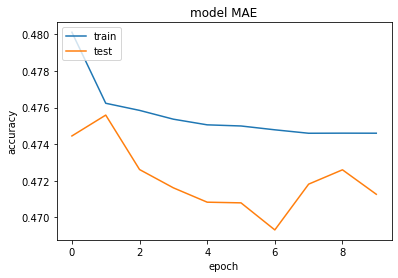

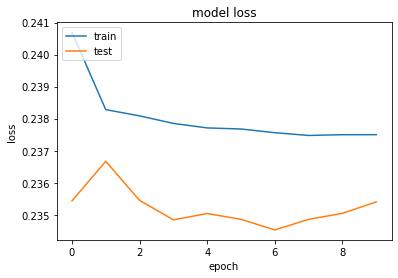

In [41]:
%matplotlib inline
import pickle
import numpy as np
from matplotlib import pyplot as plt

plt.plot(h.history['MAE'])
plt.plot(h.history['val_MAE'])
plt.title('model MAE')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(h.history['loss'])
plt.plot(h.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [42]:
def denormalize_time(time):
    '''
    denormalize time (datetime.time to values bertween 0 and 1
    '''
    max_time = 24 * 60 * 60 + 60 * 60 + 60
    return pd.Timestamp(time * max_time, unit='s').time()

In [43]:
i = 0

a = tf.reshape(val_time[i], (1,1))

b = tf.reshape(val_street[i], (1,1))

c = tf.reshape(val_weekday[i], (1,1))

d = tf.reshape(val_past_ocup[i], (1,1))

e = tf.reshape(val_last_past_ocup[i], (1,1))

f = tf.reshape(val_month[i], (1,1))

    
print('Time:      ', denormalize_time(a.numpy()[0][0]))
print('Street:    ', b.numpy()[0][0])
print('Weekday:   ', c.numpy()[0][0])
print('Past ocup: ', d.numpy()[0][0])
print('Last past ocup: ', e.numpy()[0][0])
print('Month:     ', f.numpy()[0][0])
print('')
print('Targets:       ', val_targets[i].numpy())
print('Dif past ocup: ', val_dif_past_ocup[i].numpy())

Time:       10:08:00
Street:     53.0
Weekday:    1.0
Past ocup:  9.0
Last past ocup:  5.0
Month:      11.0

Targets:        1.0
Dif past ocup:  -2.0


In [44]:
print('Operacion predicha:   ', model.predict([a, b, c, e, f])[0][0])

print('Operacion real:        ', val_targets[i].numpy())
#print('Dif past ocup:    ', val_dif_past_ocup[i].numpy())

Operacion predicha:    0.6268184
Operacion real:         1.0


# Haciendolo un clasificador

In [45]:
from keras.utils import to_categorical


new_train_targets = to_categorical(train_targets)
new_val_targets = to_categorical(val_targets)

Using TensorFlow backend.


In [46]:
#Time 
input_time = Input(shape=(1), name='input_time')
#dense_time = Dense(128, activation='relu')(input_time)

#Street
input_street = Input(shape=(1), name='input_street')
emb_street = Embedding(input_length=1, input_dim=max_street_num+1, output_dim=80)(input_street)
flat_street = Flatten()(emb_street)

#Weekday
input_weekday = Input(shape=(1), name='input_weekday')
emb_weekday = Embedding(input_length=1, input_dim=7, output_dim=50)(input_weekday)
flat_weekday = Flatten()(emb_weekday)

#Month
input_month = Input(shape=(1), name='input_month')
emb_month = Embedding(input_length=1, input_dim=13, output_dim=40)(input_month)
flat_month = Flatten()(emb_month)

#Past ocupation
input_past_ocupation = Input(shape=(1), name='input_past_ocupation')

#Last past ocupation
input_last_past_ocupation = Input(shape=(1), name='input_last_past_ocupation')


concat = Concatenate(axis=-1)
input_merge = concat([input_time, flat_street])
input_merge = concat([input_merge, flat_weekday])
input_merge = concat([input_merge, flat_month])
input_merge = concat([input_merge, input_last_past_ocupation])

d = BatchNormalization()(input_merge)
#d = Dropout(0.25)(d)
d = Dense(128, activation='relu')(d)
d = BatchNormalization()(d)
#d = Dropout(0.25)(d)
#d = Dense(256, activation='relu')(d)
#d = Dropout(0.25)(d)
#d = Dense(512, activation='relu')(d)
#d = Dropout(0.25)(d)
#d = Dense(128, activation='relu')(d)
#d = Dropout(0.5)(d)
#d = Dense(128, activation='relu')(d)
out = Dense(2, activation='softmax')(d)

model = Model(inputs=[input_time, input_street, input_weekday, input_last_past_ocupation, input_month], outputs=out)
#model = Model(inputs=[input_time, input_street, input_weekday, input_month], outputs=out)
model.summary()
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_street (InputLayer)       [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding_6 (Embedding)         (None, 1, 80)        7760        input_street[0][0]               
__________________________________________________________________________________________________
input_weekday (InputLayer)      [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_time (InputLayer)         [(None, 1)]          0                                            
____________________________________________________________________________________________

In [47]:
red_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=4, min_lr=0.00000001)

h = model.fit([train_time, train_street, train_weekday, train_last_past_ocup, train_month], new_train_targets, epochs=10, batch_size=128, validation_data=([val_time, val_street, val_weekday, val_last_past_ocup, val_month], new_val_targets), callbacks=[red_lr])

Train on 2337946 samples, validate on 584541 samples
Epoch 1/10
2337946/2337946 [==============================] - 63s 27us/sample - loss: 0.6729 - accuracy: 0.5711 - val_loss: 0.6614 - val_accuracy: 0.5868
Epoch 2/10
2337946/2337946 [==============================] - 61s 26us/sample - loss: 0.6639 - accuracy: 0.5849 - val_loss: 0.6632 - val_accuracy: 0.5855
Epoch 3/10
2337946/2337946 [==============================] - 61s 26us/sample - loss: 0.6626 - accuracy: 0.5868 - val_loss: 0.6595 - val_accuracy: 0.5901
Epoch 4/10
2337946/2337946 [==============================] - 60s 26us/sample - loss: 0.6618 - accuracy: 0.5883 - val_loss: 0.6592 - val_accuracy: 0.5911
Epoch 5/10
2337946/2337946 [==============================] - 60s 26us/sample - loss: 0.6615 - accuracy: 0.5883 - val_loss: 0.6591 - val_accuracy: 0.5904
Epoch 6/10
2337946/2337946 [==============================] - 61s 26us/sample - loss: 0.6612 - accuracy: 0.5888 - val_loss: 0.6592 - val_accuracy: 0.5902
Epoch 7/10
2337946/2337

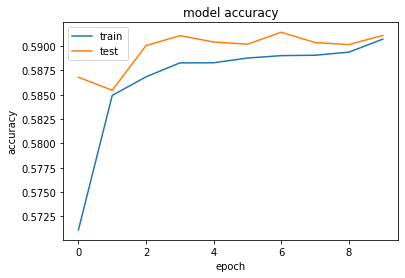

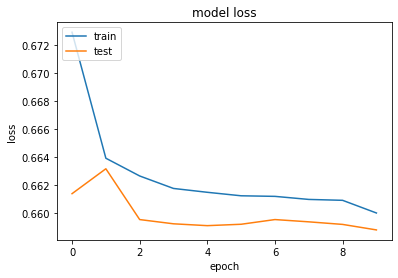

In [48]:
%matplotlib inline
import pickle
import numpy as np
from matplotlib import pyplot as plt

plt.plot(h.history['accuracy'])
plt.plot(h.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(h.history['loss'])
plt.plot(h.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Hacer 1/x siendo x el valor de la ocupacion asi restrinjo los valores entre 0 y 1 y los normalizo